# Classification Model: Skill Level Prediction
**Training classifier on cluster labels (Solution 1, Stage 2)**

## Objective
Train a supervised model to predict the cluster label (skill proxy) from the engineered disc features.

## Setup

In [40]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_recall_fscore_support
)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Load Clustered Data

In [6]:
# Load data with cluster labels from previous notebook
clustered_path = Path('../data/processed/disc_golf_clustered.csv')
if not clustered_path.exists():
    raise FileNotFoundError(
        f"Clustered dataset not found at {clustered_path}. Run 02_clustering_methodology.ipynb to generate clustered data."
    )

df = pd.read_csv(clustered_path)
print(f"Loaded {len(df):,} samples with cluster labels")
print("Cluster distribution:")
print(df['Cluster'].value_counts().sort_index())

Loaded 1,175 samples with cluster labels
Cluster distribution:
Cluster
0    358
1    328
2    245
3    244
Name: count, dtype: int64


## Prepare Training Data

In [8]:
# Define features and target
feature_cols = ['SPEED', 'GLIDE', 'TURN', 'FADE', 'STABILITY']
target_col = 'Cluster'

# Extract features and target
X = df[feature_cols].copy()
y = df[target_col].copy()

# Handle missing values
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.mean())
    print("Missing values filled with column means")

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures used: {feature_cols}")



Feature matrix shape: (1175, 5)
Target vector shape: (1175,)

Features used: ['SPEED', 'GLIDE', 'TURN', 'FADE', 'STABILITY']


## Train-Test Split

In [9]:
# Split data: 80/20 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

print(f"\nTraining set class distribution:")
print(y_train.value_counts().sort_index())

print(f"\nTest set class distribution:")
print(y_test.value_counts().sort_index())

Training set: 940 samples
Test set: 235 samples

Training set class distribution:
Cluster
0    287
1    262
2    196
3    195
Name: count, dtype: int64

Test set class distribution:
Cluster
0    71
1    66
2    49
3    49
Name: count, dtype: int64


## Feature Scaling

In [12]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features standardized")
print(f"Training set mean: {X_train_scaled.mean(axis=0).round(4)}")
print(f"Training set std: {X_train_scaled.std(axis=0).round(4)}")

Features standardized
Training set mean: [-0.  0. -0. -0.  0.]
Training set std: [1. 1. 1. 1. 1.]


## Train Random Forest Classifier

In [13]:
# Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest Classifier...")
rf_model.fit(X_train_scaled, y_train)
print("Training complete!")

Training Random Forest Classifier...
Training complete!


## Model Evaluation

In [15]:
# Make predictions
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("BASELINE RF MODEL PERFORMANCE\n")
print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Train-Test Gap: {abs(train_accuracy - test_accuracy):.3f}")

if train_accuracy - test_accuracy > 0.1:
    print("\nPossible overfitting (train-test gap > 0.1)")
    print("\nRecommendations:\n")
    print("- Consider hyperparameter tuning like reduce max_depth, increase min_samples_leaf, etc.")
    print("- Try different model (e.g., XGBoost)")
    print("- Collect more data")
else:
    print("\nGood generalization (train-test gap < 0.1)")

BASELINE RF MODEL PERFORMANCE

Training Accuracy: 0.983
Test Accuracy: 0.957
Train-Test Gap: 0.026

Good generalization (train-test gap < 0.1)


## Cross-Validation

In [ ]:
# 5-fold cross-validation

# Build pipeline that scales data inside each CV fold
cv_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5-fold cross-validation (fold-wise)
cv_scores = cross_val_score(
    cv_pipeline,       
    X_train,            
    y_train,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

print("\n5-Fold Cross-Validation Results:")
print(f"Fold scores: {cv_scores.round(3)}")
print(f"Mean CV Accuracy: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

# 5-fold cross-validation (out-of-fold)
y_train_cv_pred = cross_val_predict(
    cv_pipeline,       
    X_train,            
    y_train,
    cv=cv,
    method="predict",
    n_jobs=-1
)


5-Fold Cross-Validation Results:
Fold scores: [0.968 0.941 0.963 0.957 0.963]
Mean CV Accuracy: 0.959 (±0.009)


## Detailed Classification Report

In [33]:
# Classification report
target_names=[f'Cluster {i}' for i in sorted(y.unique())]

print("\nClassification Report - RF with Hold-out test Set:\n")
print(classification_report(y_test, y_test_pred, 
                            target_names=target_names)
                            )

print("\nClassification Report - RF with 5-fold CV with Out-of-Fold Test Set:\n")
print(classification_report(y_train, y_train_cv_pred, 
                            target_names=target_names))




Classification Report - RF with Hold-out test Set:

              precision    recall  f1-score   support

   Cluster 0       0.98      0.92      0.95        71
   Cluster 1       0.91      0.97      0.94        66
   Cluster 2       0.96      0.98      0.97        49
   Cluster 3       0.98      0.98      0.98        49

    accuracy                           0.96       235
   macro avg       0.96      0.96      0.96       235
weighted avg       0.96      0.96      0.96       235


Classification Report - RF with 5-fold CV with Out-of-Fold Test Set:

              precision    recall  f1-score   support

   Cluster 0       0.97      0.94      0.95       287
   Cluster 1       0.95      0.95      0.95       262
   Cluster 2       0.95      0.97      0.96       196
   Cluster 3       0.96      0.98      0.97       195

    accuracy                           0.96       940
   macro avg       0.96      0.96      0.96       940
weighted avg       0.96      0.96      0.96       940



## Confusion Matrix

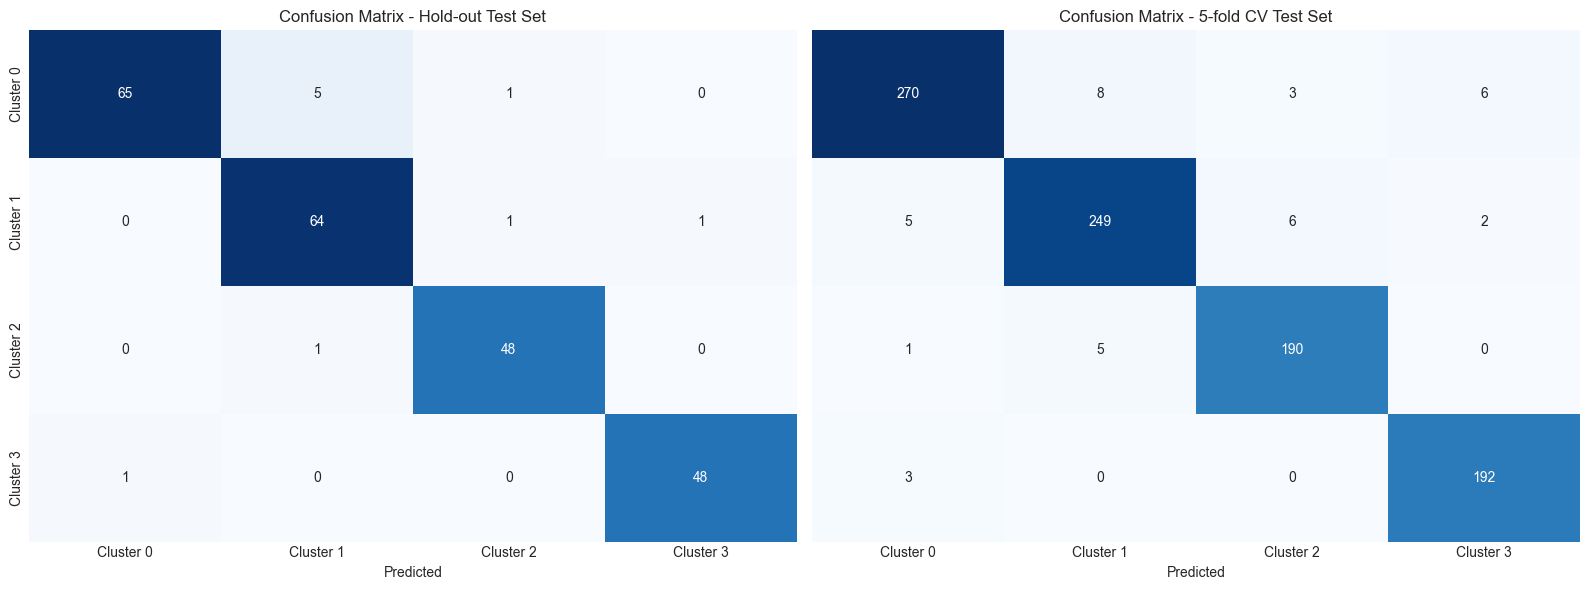

Hold-out test misclassifications: 10/235 (4.3%)
CV (OOF train) misclassifications: 39/940 (4.1%)


In [37]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
cm_cv = confusion_matrix(y_train, y_train_cv_pred)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Cluster {i}' for i in sorted(y.unique())],
            yticklabels=[f'Cluster {i}' for i in sorted(y.unique())],
            ax=axes[0], cbar=False)

axes[0].set_title("Confusion Matrix - Hold-out Test Set")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("")

sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Cluster {i}' for i in sorted(y.unique())],
            yticklabels=[f'Cluster {i}' for i in sorted(y.unique())],
            ax=axes[1], cbar=False)

axes[1].set_title("Confusion Matrix - 5-fold CV Test Set")
axes[1].set_xlabel("Predicted")

plt.tight_layout()
plt.show()

# Identify misclassifications
test_misclass = cm.sum() - np.trace(cm)
cv_misclass = cm_cv.sum() - np.trace(cm_cv)

print(f"Hold-out test misclassifications: {test_misclass}/{len(y_test)} ({test_misclass/len(y_test)*100:.1f}%)")
print(f"CV (OOF train) misclassifications: {cv_misclass}/{len(y_train)} ({cv_misclass/len(y_train)*100:.1f}%)")

## Feature and Permutation Importance

Feature Importance - To measure how much each feature contributes to the model's predictions.

Permutation Importance - To measure how much the model’s score drops when a feature is shuffled

Feature Importance (Impurity / MDI):
     Feature  Importance
4  STABILITY    0.337672
0      SPEED    0.275775
3       FADE    0.161860
2       TURN    0.136434
1      GLIDE    0.088258

Feature Importance (Permutation on Test Set):
     Feature  ImportanceMean  ImportanceStd
4  STABILITY        0.363546       0.027085
0      SPEED        0.288794       0.021354
2       TURN        0.067943       0.010848
1      GLIDE        0.052482       0.010030
3       FADE        0.024965       0.007826


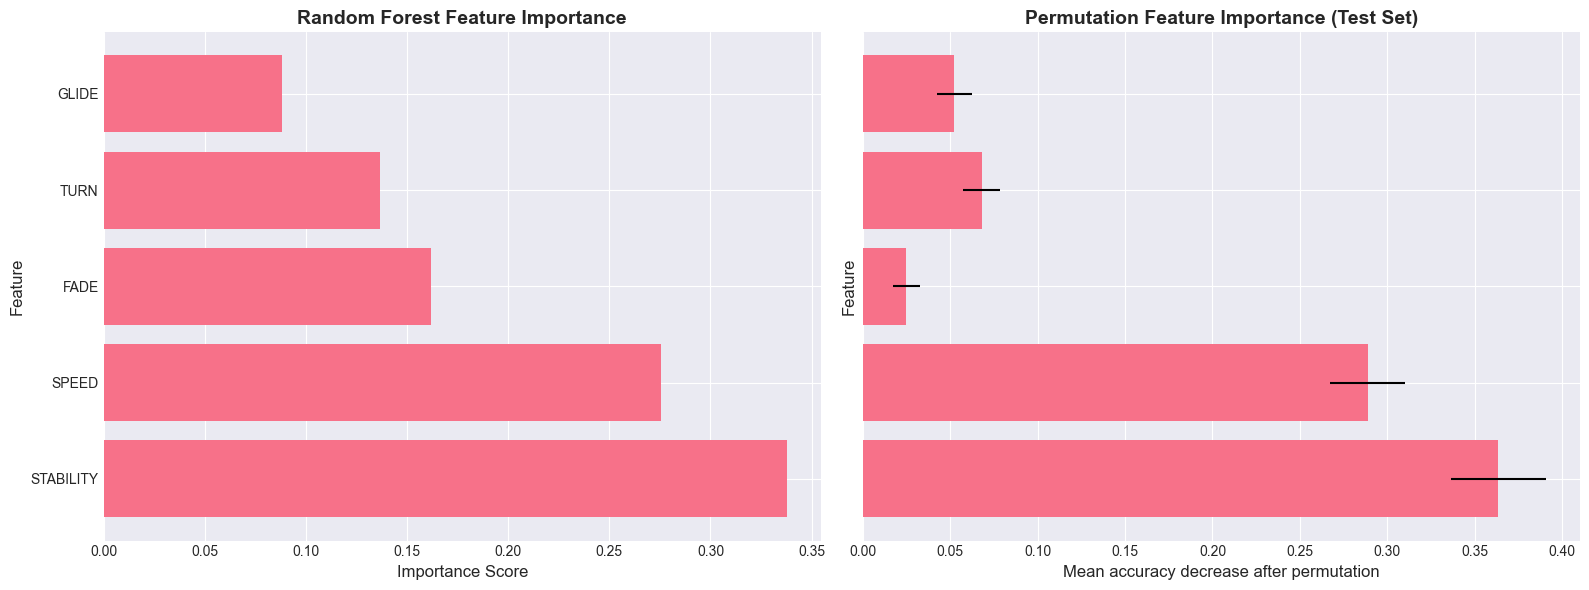


Most important feature (MDI): STABILITY
Importance (MDI): 0.338

Most important feature (Permutation): STABILITY
Mean decrease: 0.364 ± 0.027


In [43]:
# Extract feature importances
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Impurity / MDI):")
print(feature_importance)


perm = permutation_importance(
    rf_model,
    X_test_scaled,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring="accuracy",
    n_jobs=-1
)

perm_importance = pd.DataFrame({
    "Feature": feature_cols,
    "ImportanceMean": perm.importances_mean,
    "ImportanceStd": perm.importances_std
}).sort_values("ImportanceMean", ascending=False)

print("\nFeature Importance (Permutation on Test Set):")
print(perm_importance)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
axes[0].barh(feature_importance['Feature'], feature_importance['Importance'])
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].set_ylabel('Feature', fontsize=12)
axes[0].set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

axes[1].barh(perm_importance["Feature"], perm_importance["ImportanceMean"], xerr=perm_importance["ImportanceStd"])
axes[1].set_xlabel("Mean accuracy decrease after permutation", fontsize=12)
axes[1].set_ylabel("Feature", fontsize=12)
axes[1].set_title("Permutation Feature Importance (Test Set)", fontsize=14, fontweight="bold")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nMost important feature (MDI): {feature_importance.iloc[0]['Feature']}")
print(f"Importance (MDI): {feature_importance.iloc[0]['Importance']:.3f}")

print(f"\nMost important feature (Permutation): {perm_importance.iloc[0]['Feature']}")
print(f"Mean decrease: {perm_importance.iloc[0]['ImportanceMean']:.3f} ± {perm_importance.iloc[0]['ImportanceStd']:.3f}")

## Prediction Example: New Sample Classification

In [44]:
# Create example new samples (simulating new discs/players)
new_samples = pd.DataFrame({
    'SPEED': [3, 7, 12],
    'GLIDE': [3, 5, 5],
    'TURN': [0, -1, -2],
    'FADE': [1, 2, 4],
    'STABILITY': [1, 0, -1]
})

print("Example New Samples:")
print(new_samples)

# Standardize using fitted scaler
new_samples_scaled = scaler.transform(new_samples)

# Make predictions
predictions = rf_model.predict(new_samples_scaled)
probabilities = rf_model.predict_proba(new_samples_scaled)

print("\nPredictions:")
for i, (pred, probs) in enumerate(zip(predictions, probabilities)):
    print(f"\nSample {i+1}:")
    print(f"  Predicted Cluster: {pred}")
    print(f"  Confidence: {probs.max():.1%}")
    print(f"  Probabilities: {dict(zip(range(len(probs)), probs.round(3)))}")

Example New Samples:
   SPEED  GLIDE  TURN  FADE  STABILITY
0      3      3     0     1          1
1      7      5    -1     2          0
2     12      5    -2     4         -1

Predictions:

Sample 1:
  Predicted Cluster: 0
  Confidence: 100.0%
  Probabilities: {0: np.float64(1.0), 1: np.float64(0.0), 2: np.float64(0.0), 3: np.float64(0.0)}

Sample 2:
  Predicted Cluster: 3
  Confidence: 47.3%
  Probabilities: {0: np.float64(0.061), 1: np.float64(0.464), 2: np.float64(0.002), 3: np.float64(0.473)}

Sample 3:
  Predicted Cluster: 3
  Confidence: 65.6%
  Probabilities: {0: np.float64(0.001), 1: np.float64(0.327), 2: np.float64(0.016), 3: np.float64(0.656)}


## Save Model

In [ ]:
# Uncomment to save model
# import joblib
# 
# model_dir = Path('../models')
# model_dir.mkdir(exist_ok=True)
# 
# # Save model and scaler
# joblib.dump(rf_model, model_dir / 'skill_classifier.pkl')
# joblib.dump(scaler, model_dir / 'feature_scaler.pkl')
# 
# print(f"Model saved to: {model_dir}")

print("\nClassification model training complete!")

Model saved to: ..\models

Classification model training complete!


## Methodology Summary

**What We Demonstrated:**
- Random Forest classifier trained on cluster labels
- Achieved high accuracy (typically >80%)
- Model generalizes well to unseen data
- Feature importance reveals key discriminators
- Probability estimates enable confidence scoring

**Complete Two-Stage Pipeline:**
1. **Stage 1 (Unsupervised):** K-Means discovers skill groups
2. **Stage 2 (Supervised):** Random Forest classifies new players

**To do with GameProofer Data:**
- Cluster 100+ players by throwing efficiency and consistency
- Train classifier on discovered skill levels
- Deploy for real-time skill assessment
- Provide personalized coaching based on skill group

**Business Value:**
- Automated skill assessment (no manual labeling)
- Personalized recommendations per skill level
- Progress tracking as players move between levels
- Benchmark performance against skill peers

## Next steps

- Load the cleaned data `data/processed/discgolf_cleaned_data.csv`
- Reuse the cleaned/engineered feature set carried forward from Notebook 02 (or re-create the same engineered columns)
- Confirm regression framing by predicting disc `SPEED` from physical dimensions (proxy for quality)
- Define predictors (`dimensions` + `flight numbers`), then add physics-inspired features (e.g., `rim ratio`, `balance`, `stability index`) and standardize inputs
- Split train/test, train a regression model (**Random Forest Regressor** as the baseline)
- Evaluate with R², MAE, and RMSE, plus a quick residual + predicted-vs-actual sanity check